# Dim 3 point 

Compare trained only on DG vs P2L

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
import sys
sys.path.append('../../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-19 19:32:35.449134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-19 19:32:35.467287: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-19 19:32:35.472758: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup experiment

We use the non-dim training here. This is so that the model can easily focus on data from both experiments.

The tests done in folder comparing dim and non-dim showed that non-dim and dim models can have similar skill. 

In [20]:
# We need one place to save all the experiment relevant info.  
experiment_config= {'simulation_names':['DG','P2L'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    'window_size':3, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          #'mag_nabla_h_widened',
                                          #'filter_scale', 
                                          #'mag_nabla_u_widened',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated_nondim',
                                          'vphp_rotated_nondim'],
                    
                    'coeff_channels'  : [], 

                    'extra_channels'   : ['uphp_rotated',
                                        'vphp_rotated', 
                                        'mag_nabla_h_widened',
                                        'mag_nabla_u_widened',
                                        'filter_scale'],

                    'use_coeff_channels': False,

                    'all_time_range': slice(200, 3600),
                    'train_time_range': slice(0, 2048),
                    'test_time_range' : slice(-128, None),
                    'eval_time_range' : slice(-256, -128),
                    'num_train_batches': 128, 
                    'num_test_batches' : 8, 

                    #'num_inputs': 55, 
                    'network_shape': [48, 48, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/shape_48_48_2/'
                    
            }
experiment_config['num_inputs'] = len(experiment_config['input_channels']) * experiment_config['window_size']**2

## SimulationData Module
#### Load data for different simulations and prepare it with right variables and non-dims.

In this step all the variables and extra dimensions may be created that were not originally present. 
Each input and output variable gets its own containing variable (e.g. if top and bottom layer were two separate inputs, then in this step they may get separated out). 
Other examples might be that rotated variables, or magnitudes become their own variables in this step. 

In [6]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'], 
                             time_sel = experiment_config['all_time_range'],
                             single_layer_mask_flag=True
                             )

In [10]:
DT.simulation_data['DG']['100']

DataTree('100', parent="DG")
    Dimensions:                      (Time: 3400, xh: 100, yh: 108, zl: 2, Xn: 3,
                                      Yn: 3, zi: 3)
    Coordinates:
      * Time                         (Time) object 27kB 0006-07-04 00:00:00 ... 0...
      * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
      * yh                           (yh) float64 864B 30.27 30.45 ... 49.55 49.73
      * zl                           (zl) float64 16B 1.035e+03 1.036e+03
      * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
    Dimensions without coordinates: Xn, Yn
    Data variables: (12/67)
        dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(16, 2, 107, 99, 3, 3), meta=np.ndarray>
        ...                           ...
        uphp_rotated_nondim          (Time, zl, yh, xh) float64 588MB dask.array<chunksize=(16, 2, 107, 99), meta=np.ndarray>
        vphp_rotated_nondim          (Time, zl, yh, xh) float64 588MB dask.array<chunksize=(16, 2, 107, 99), meta=np.ndarray>
        uphp_nondim                  (Time, zl, yh, xh) float64 588MB dask.array<chunksize=(16, 2, 107, 99), meta=np.ndarray>
        vphp_nondim                  (Time, zl, yh, xh) float64 588MB dask.array<chunksize=(16, 2, 107, 99), meta=np.ndarray>
        Rd_nondim                    (Time, yh, xh) float64 294MB dask.array<chunksize=(16, 108, 100), meta=np.ndarray>
        single_layer_mask            (Time, yh, xh) float64 294MB dask.array<chunksize=(16, 108, 100), meta=np.ndarray>
    Attributes:
        simulation_name:  DG
        filter_scale:     100
        source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
        description:      Dataset for DG experiment at 100 km resolution

In [11]:
DT.simulation_data['P2L']['100']

DataTree('100', parent="P2L")
    Dimensions:                      (Time: 3400, xh: 60, yh: 78, zl: 2, Xn: 3,
                                      Yn: 3, zi: 3)
    Coordinates:
      * Time                         (Time) object 27kB 0006-07-04 00:00:00 ... 0...
      * xh                           (xh) float64 480B 10.0 30.0 ... 1.19e+03
      * yh                           (yh) float64 624B 30.0 50.0 ... 1.57e+03
      * zl                           (zl) float64 16B 1.031e+03 1.033e+03
      * zi                           (zi) float64 24B 1.03e+03 1.032e+03 1.034e+03
    Dimensions without coordinates: Xn, Yn
    Data variables: (12/67)
        dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 2GB dask.array<chunksize=(16, 2, 77, 59, 3, 3), meta=np.ndarray>
        dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 2GB dask.array<chunksize=(16, 2, 77, 59, 3, 3), meta=np.ndarray>
        dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 2GB dask.array<chunksize=(16, 2, 77, 59, 3, 3), meta=np.ndarray>
        dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 2GB dask.array<chunksize=(16, 2, 77, 59, 3, 3), meta=np.ndarray>
        dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 2GB dask.array<chunksize=(16, 2, 77, 59, 3, 3), meta=np.ndarray>
        dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 2GB dask.array<chunksize=(16, 2, 77, 59, 3, 3), meta=np.ndarray>
        ...                           ...
        uphp_rotated_nondim          (Time, zl, yh, xh) float64 255MB dask.array<chunksize=(16, 2, 77, 59), meta=np.ndarray>
        vphp_rotated_nondim          (Time, zl, yh, xh) float64 255MB dask.array<chunksize=(16, 2, 77, 59), meta=np.ndarray>
        uphp_nondim                  (Time, zl, yh, xh) float64 255MB dask.array<chunksize=(16, 2, 77, 59), meta=np.ndarray>
        vphp_nondim                  (Time, zl, yh, xh) float64 255MB dask.array<chunksize=(16, 2, 77, 59), meta=np.ndarray>
        Rd_nondim                    (Time, yh, xh, zl) float64 255MB dask.array<chunksize=(16, 78, 60, 2), meta=np.ndarray>
        single_layer_mask            (Time, yh, xh) float64 127MB dask.array<chunksize=(16, 78, 60), meta=np.ndarray>
    Attributes:
        simulation_name:  P2L
        filter_scale:     100
        source:           gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/r...
        description:      Dataset for P2L experiment at 100 km resolution

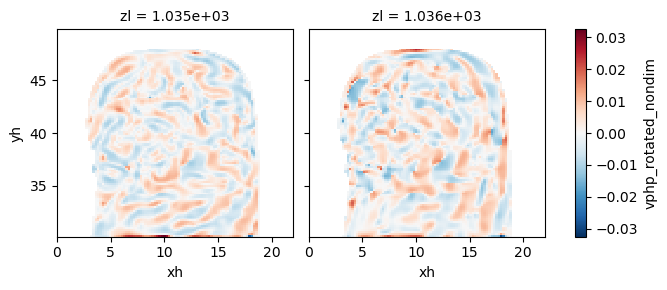

In [12]:
DT.simulation_data['DG']['100'].vphp_rotated_nondim.isel(Time=-1).plot(col='zl')

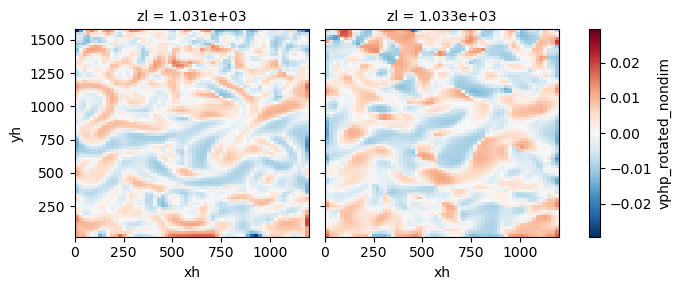

In [13]:
DT.simulation_data['P2L']['100'].vphp_rotated_nondim.isel(Time=-1).plot(col='zl')

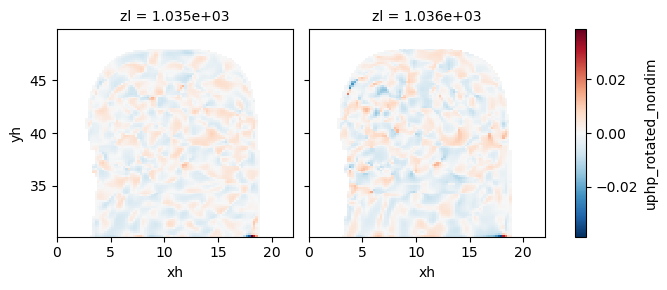

In [14]:
DT.simulation_data['DG']['100'].uphp_rotated_nondim.isel(Time=-1).plot(col='zl')

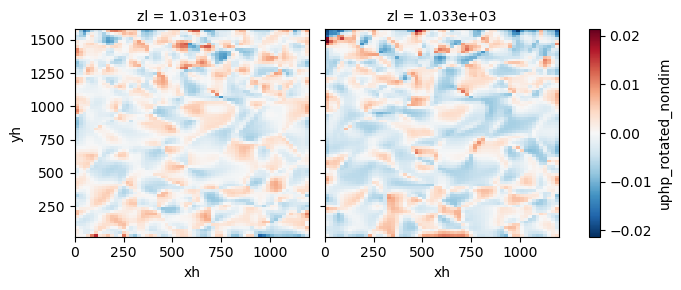

In [15]:
DT.simulation_data['P2L']['100'].uphp_rotated_nondim.isel(Time=-1).plot(col='zl')

## MLXarrayDataset 

Go from simulation data to batchesm but still as Xarray objects. 
In this step things like dropping extra points, masking of data etc happen. 

In [16]:
exp_sets = { 'DG_only': { 'sel_sim' :'DG' }, 
             'P2L_only':{ 'sel_sim' :'P2L' }, 
             'DG_P2L':{'sel_sim' :['DG','P2L']}   
            }

In [17]:
for set_keys in exp_sets.keys():
    exp_sets[set_keys]['ML_DT_train'] = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['train_time_range'],
                                       num_batches = experiment_config['num_train_batches'],
                                       choose_experiment=exp_sets[set_keys]['sel_sim'])
    exp_sets[set_keys]['ML_DT_test'] = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['test_time_range'],
                                       num_batches = experiment_config['num_test_batches'],
                                       choose_experiment=exp_sets[set_keys]['sel_sim'])

Will load : 5.3469184 gb into memory.
load took: 208.4342 seconds
Will load : 0.3341824 gb into memory.
load took: 11.7524 seconds
Will load : 2.65846784 gb into memory.
load took: 106.4240 seconds
Will load : 0.16615424 gb into memory.
load took: 7.3699 seconds
Will load : 8.00538624 gb into memory.
load took: 216.1098 seconds
Will load : 0.50033664 gb into memory.
load took: 15.6990 seconds


## MLJAXDataset 

### Convert these xbatcher batches to processed ones for training

This needs to take care of extra dims, like Xn,Yn.

In [18]:
for set_keys in exp_sets.keys():

    exp_sets[set_keys]['train_ML_data'] = datasets.MLJAXDataset(exp_sets[set_keys]['ML_DT_train'], 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'], 
                                      use_coeff_channels=experiment_config['use_coeff_channels'],
                                      do_normalize=True)

    exp_sets[set_keys]['test_ML_data'] = datasets.MLJAXDataset(exp_sets[set_keys]['ML_DT_test'], 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'],
                                      use_coeff_channels=experiment_config['use_coeff_channels'],
                                      do_normalize=True)


## AnnRegressionSystem (and associated NN setup modules ArtificialNeuralNetwork and PointwiseANN).


In [ ]:
for set_keys in exp_sets.keys():
    ML_data_combo = {'train_data':exp_sets[set_keys]['train_ML_data'], 'test_data':exp_sets[set_keys]['test_ML_data']}
    
    ANN_model = ML_classes.PointwiseANN(num_in = experiment_config['num_inputs'],
                                        shape = experiment_config['network_shape'],
                                       random_key=1) 
    #networks[model_key]['num_params'] = ANN_model.count_parameters()
    
    regress_sys = ML_classes.AnnRegressionSystem(ANN_model, loss_type='mae')

    print('Start training: ', set_keys)
    regress_sys.train_system(ML_data_combo, num_epoch=501, print_freq=20, min_relative_improvement=1e-3)
    
    exp_sets[set_keys]['regress_sys'] = regress_sys

    exp_sets[set_keys]['save_dir'] = experiment_config['exp_ckpt_save_dir'] + set_keys

    regress_sys.save_checkpoint(exp_sets[set_keys]['save_dir'])

Start training:  DG_only
At epoch 1. Train loss :  0.24237874918617308 , Test loss: 0.21586696431040764 , Test R2: -0.022303730249404907
At epoch 21. Train loss :  0.18679527251515538 , Test loss: 0.18318586237728596 , Test R2: 0.12473656237125397
At epoch 41. Train loss :  0.18320934905204922 , Test loss: 0.17836837098002434 , Test R2: 0.15626364201307297
At epoch 61. Train loss :  0.18084225989878178 , Test loss: 0.1765726748853922 , Test R2: 0.17280492186546326
At epoch 81. Train loss :  0.17936571955215186 , Test loss: 0.17527018301188946 , Test R2: 0.18642256408929825
At epoch 101. Train loss :  0.17840846569743007 , Test loss: 0.17364579625427723 , Test R2: 0.1912400722503662
Early stopping at epoch 101. No improvement in 10 epochs.
Restored best model with smoothed test loss 0.174388
Start training:  P2L_only
At epoch 1. Train loss :  0.22507661709096283 , Test loss: 0.1910130027681589 , Test R2: 0.33997224271297455
At epoch 21. Train loss :  0.14761622075457126 , Test loss: 0.1

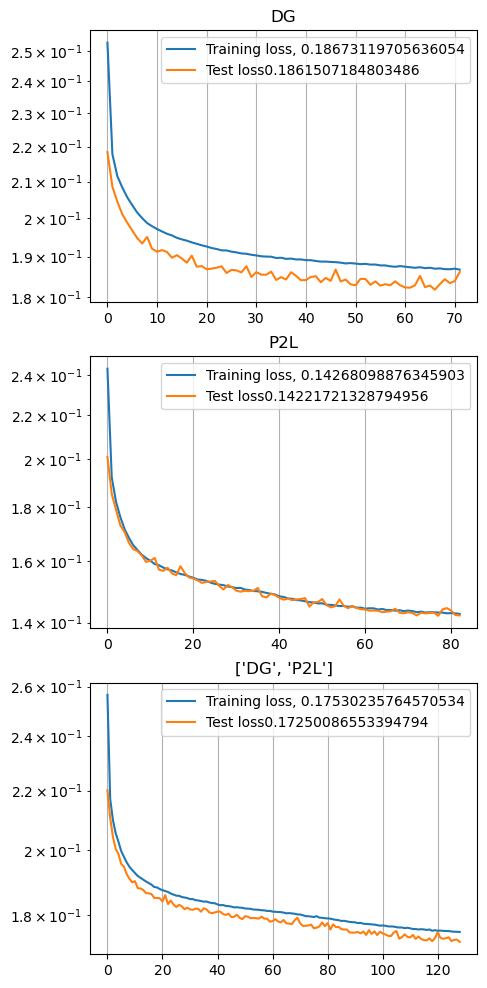

In [19]:
## Loss plot
num_models = len(exp_sets.keys())

fig = plt.figure(figsize=(5, 4*num_models))  

for i, set_keys in enumerate(exp_sets.keys()):
    regress_sys = exp_sets[set_keys]['regress_sys'] 
    plt.subplot(num_models, 1, i+1)
    plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
    plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

    plt.grid()
    plt.yscale('log')
    plt.title(exp_sets[set_keys]['sel_sim'])
    plt.legend()

In [18]:
2+2

4